In [46]:
simulation_num <- 3


maxsteps = 100
my.minlam <- 10^(-5)
nfold <- 10
outerCV_folds <- 5
graphComponents <- 2
percent <- 0.8

feature.names <- c("A", "B")

intercept_mode <- TRUE

outPath <- "~/mount2/flassoTool/simulation/sim/"
dir.create(outPath,showWarnings = F)

source('~/mount2/flassoTool/wrapper_functions_RSSmeasureModelSelection_gamma_parallel.R')
source('~/mount2/flassoTool/UtilityFunctions_sequentialCV.R')


In [47]:
feature.names <- c("A", "B")
fileName <- paste("simulation",simulation_num, sep="")

In [48]:
data.x <- as.matrix(read.table(paste("~/mount2/flassoTool/simulation/fl_sim_features_",simulation_num,".txt", sep="")))
data.y <- as.numeric(readLines(paste("~/mount2/flassoTool/simulation/fl_sim_response_",simulation_num,".txt", sep="")))

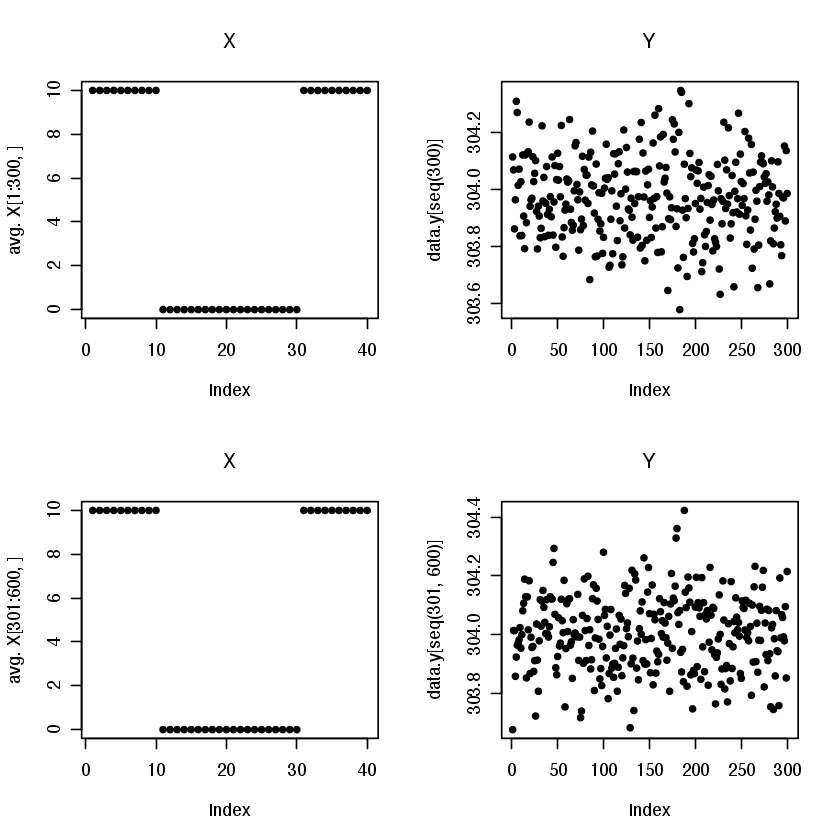

In [49]:
par(mfrow= c(2,2));
plot(colMeans(data.x[seq(300),]), main= "X", ylab= "avg. X[1:300, ]", pch= 20)
plot(data.y[seq(300)], main= "Y", pch= 20)
plot(colMeans(data.x[seq(301, 600),]), main= "X", ylab= "avg. X[301:600, ]", pch= 20)
plot(data.y[seq(301, 600)], main= "Y", pch= 20)


In [50]:
bestGammasIdx <- 1
ctr <- 1

shuffle <- sample(length(data.y))
data.x <- data.x[shuffle,]
data.y <- data.y[shuffle]

In [51]:
bin.cnt <- ncol(data.x)/graphComponents
edgs <- NULL
for(i in 1:graphComponents)
{
    edgs <- c(edgs,bin.cnt*(i-1)+1, rep((bin.cnt*(i-1)+2):(bin.cnt*i - 1),each=2),bin.cnt*i)
}

In [52]:
  partition <- data.partition(data.x,data.y,percent=percent)

In [53]:
train.group.rescaled <- group.rescale(partition$train$x,0,1,bin.cnt)
partition$train$x <- train.group.rescaled$x
partition$test$x <- group.rescale(partition$test$x,0,1,bin.cnt,train.group.rescaled$min,train.group.rescaled$max)$x

In [34]:
outer_CV_partitions <- get.outerCV.partitions(data.x,data.y,n.folds=outerCV_folds)

In [54]:
gammas <- 0
for(i in seq(-5,5)){
    gammas <- c(gammas,(10^i))
}

In [55]:
bestgammas <-vector(mode='numeric',length=1)
bestGammasIdx <- 1

In [37]:
fl.outerCV <- sapply(seq(outerCV_folds),function(i)fusedlasso.main_ForLambdaInterpolation(outer_CV_partitions[[i]]$train$x,outer_CV_partitions[[i]]$train$y,bin.cnt,edgs,gammas,intercept_mode))

[1] 120
[1] 30
[1] 12
[1] "0 0.000103416386807132"
[1] "1e-05 0.0182159814067825"
[1] "1e-04 0.0182307782740282"
[1] "0.001 0.0182307783577005"
[1] "0.01 0.0182307754531728"
[1] "0.1 0.0182307754716572"
[1] "1 0.0123935392458454"
[1] "10 0.0098131461189238"
[1] "100 0.00981869311441993"
[1] "1000 0.00982339143948608"
[1] "10000 0.0151222300335554"
[1] "1e+05 0.018230711702035"
[1] "search.depth=1"
 [1] "gammas="    "0"          "0"          "0"          "0"         
 [6] "0"          "0"          "0"          "0"          "0"         
[11] "0"          "best.gamma" "0"         
[1] "single gamma set"
[1] 120
[1] 30
[1] 12
[1] "0 9.73327031708545e-05"
[1] "1e-05 0.0193430883897523"
[1] "1e-04 0.019343089010705"
[1] "0.001 0.0193430873190573"
[1] "0.01 0.0193430846059609"
[1] "0.1 0.0193430857894211"
[1] "1 0.0125123081711475"
[1] "10 0.0103647017162026"
[1] "100 0.0104032972671517"
[1] "1000 0.0104075259847465"
[1] "10000 0.0146226649629148"
[1] "1e+05 0.0193432061336876"
[1] "search.de

In [56]:
  fl <- fusedlasso.main_ForLambdaInterpolation(partition$train$x,partition$train$y,bin.cnt,edgs,gammas,intercept_mode)

[1] 120
[1] 30
[1] 12
[1] "0 9.9248422416999e-05"
[1] "1e-05 0.0180907698147523"
[1] "1e-04 9.87883341717454e-05"
[1] "0.001 9.87883341719865e-05"
[1] "0.01 9.87883341718905e-05"
[1] "0.1 9.89085873938287e-05"
[1] "1 0.00010358370240297"
[1] "10 0.000109676390980678"
[1] "100 0.00015467643879349"
[1] "1000 0.00598837294508141"
[1] "10000 0.00898127143000771"
[1] "1e+05 0.00934067365851093"
[1] "search.depth=1"


In [68]:
best.cv.gamma <- fl$gamma.best
print(best.cv.gamma)

[1] 6.111111e-05


In [58]:
if(intercept_mode){
    edgs <- edgs + 1
    edgs <- c(1,1,edgs)
}

if(intercept_mode){
    fl.best <- fusedlasso(X=cbind(1,partition$train$x),y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
  }else{
    fl.best <- fusedlasso(X=partition$train$x,y=partition$train$y,graph=graph(edgs,directed=F),gamma=best.cv.gamma,maxsteps = maxsteps,minlam=my.minlam)
}


In [59]:
bestgammas[bestGammasIdx] <- fl$gamma.best

In [60]:
fl.best.min.lambda <- min(fl.best$lambda) 
beta.best <- coef.genlasso(fl.best,max(fl.best.min.lambda,fl$best.lambda))$beta
print('Done running fusedlasso.main')
cv.beta.mat.fl <- fl$cv.fl$cv.beta.mat
print(c('dim(cv.beta.mat.fl)',dim(cv.beta.mat.fl)))
cv.beta.mat.nl <- cv.beta.matrix.nl(partition$train$x,partition$train$y,nfold)

[1] "Done running fusedlasso.main"
[1] "dim(cv.beta.mat.fl)" "10"                  "41"                 
[1] "length(nl.beta)" "41"             


In [61]:
print(class(cv.beta.mat.nl))
print(class(cv.beta.mat.fl))

[1] "list"
[1] "matrix"


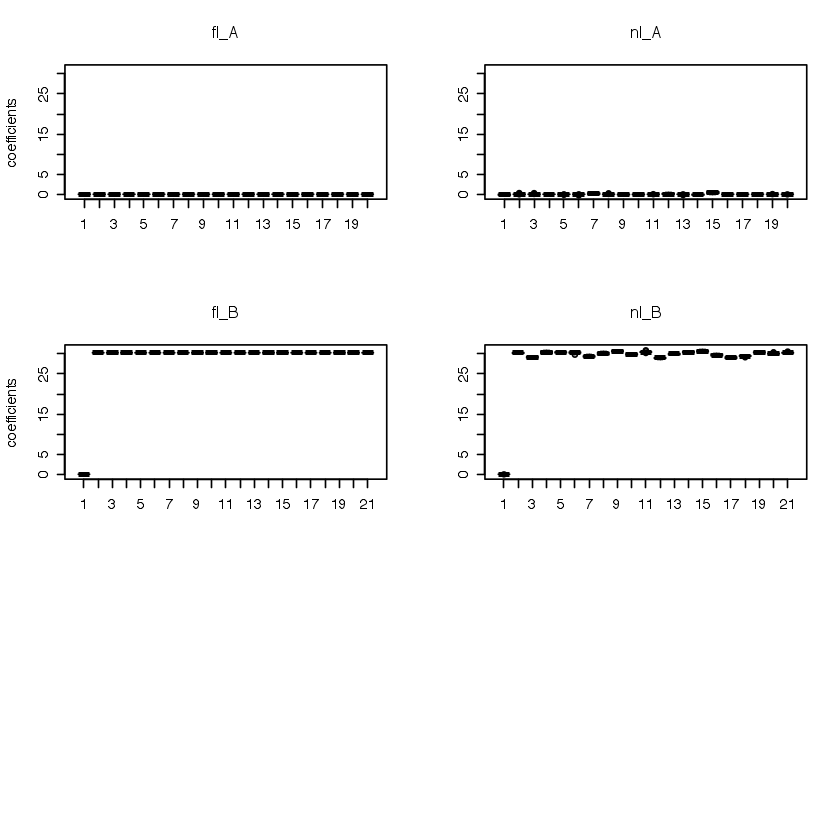

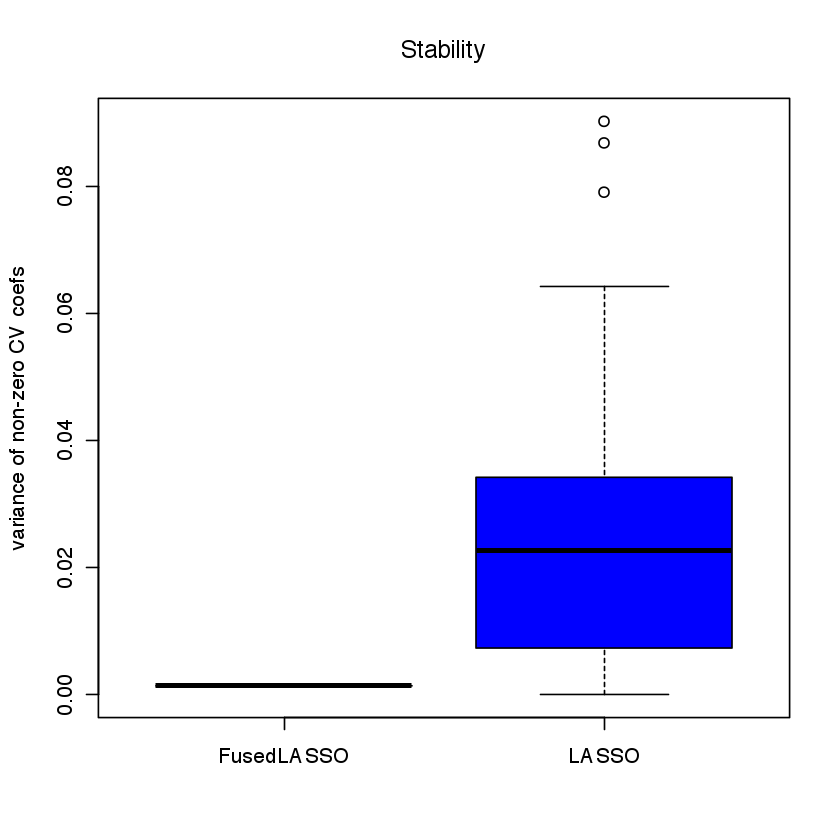

In [62]:
plot.stability(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,bin.cnt,feature.names,intercept_mode)
plot.stability.var(cv.beta.mat.fl,cv.beta.mat.nl$cv.beta,intercept_mode)

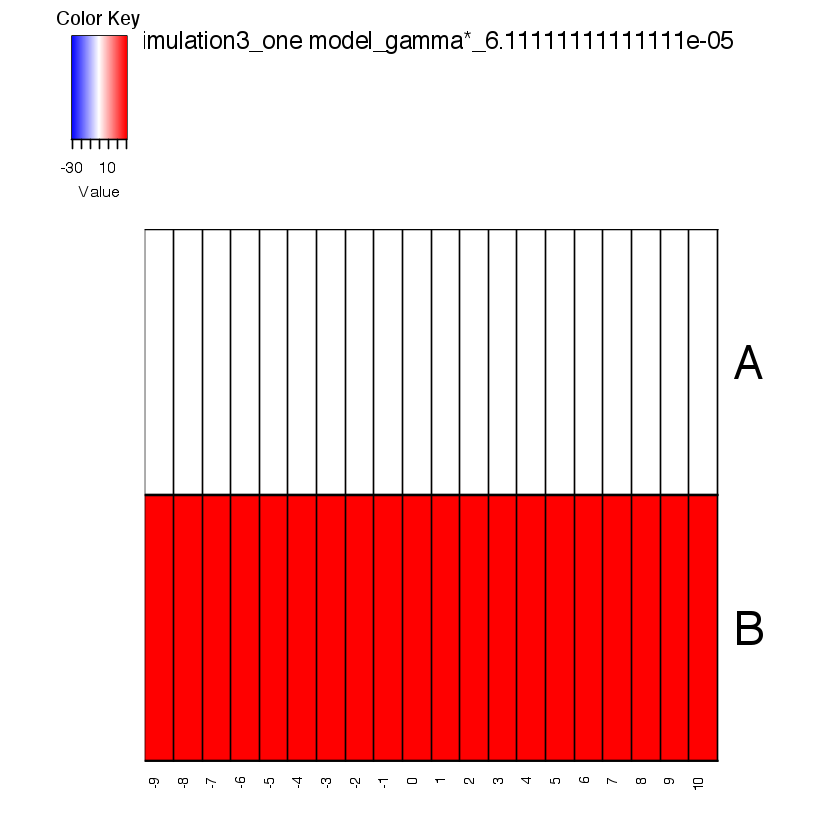

In [63]:
plot.histone.coef(beta.best,bin.cnt,feature.names,main=paste(fileName,'one model','gamma*',bestgammas[bestGammasIdx],sep='_'),intercept_mode)#,cluster_rows = F, cluster_cols = F)

In [64]:
correlations.fl <- matrix(0,ncol=3,nrow=2)#2 rows for spearman and pearson correlation and 3 columns for test, train, and entire dataset
  correlations.nl <- matrix(0,ncol=3,nrow=2)

In [65]:
test.y <- partition$test$y
  if(intercept_mode){
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(partition$train$x,partition$test$x)
  }else{
    test.x <- partition$test$x
    train.x <- partition$train$x
    entire.x <- rbind(train.x,test.x)
  }

$rss
[1] 0.01010835

$cor
[1] 1 1

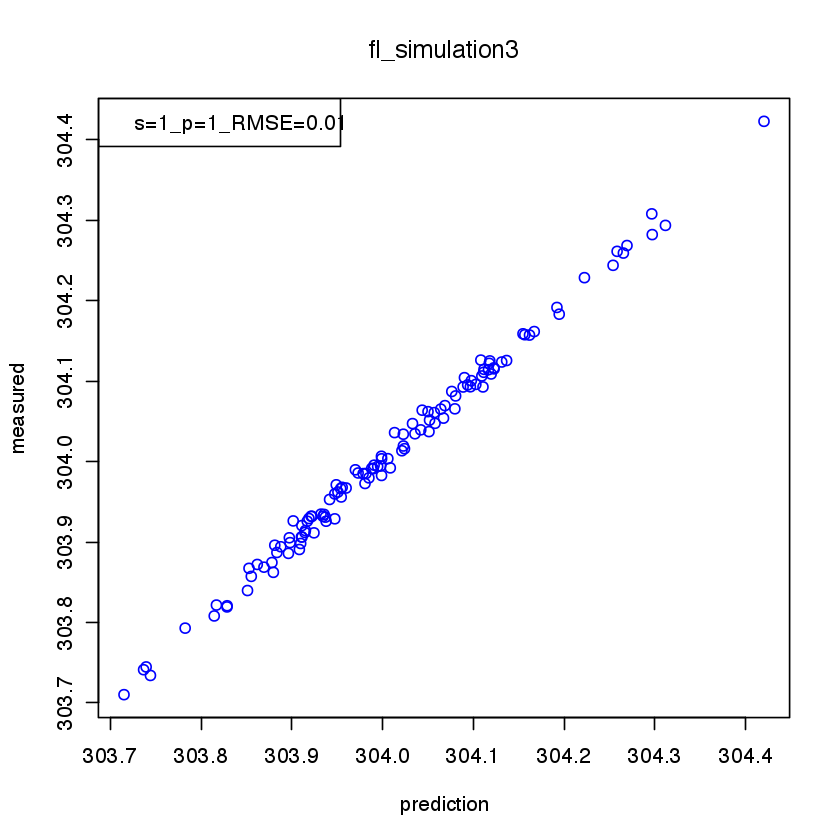

In [66]:
plot.scatter(test.x,test.y,beta.best,0,"measured",main=paste('fl',fileName,sep='_'),is_fl=T,intercept_mode,xlab='prediction')

$rss
[1] 0.01026446

$cor
[1] 1 1

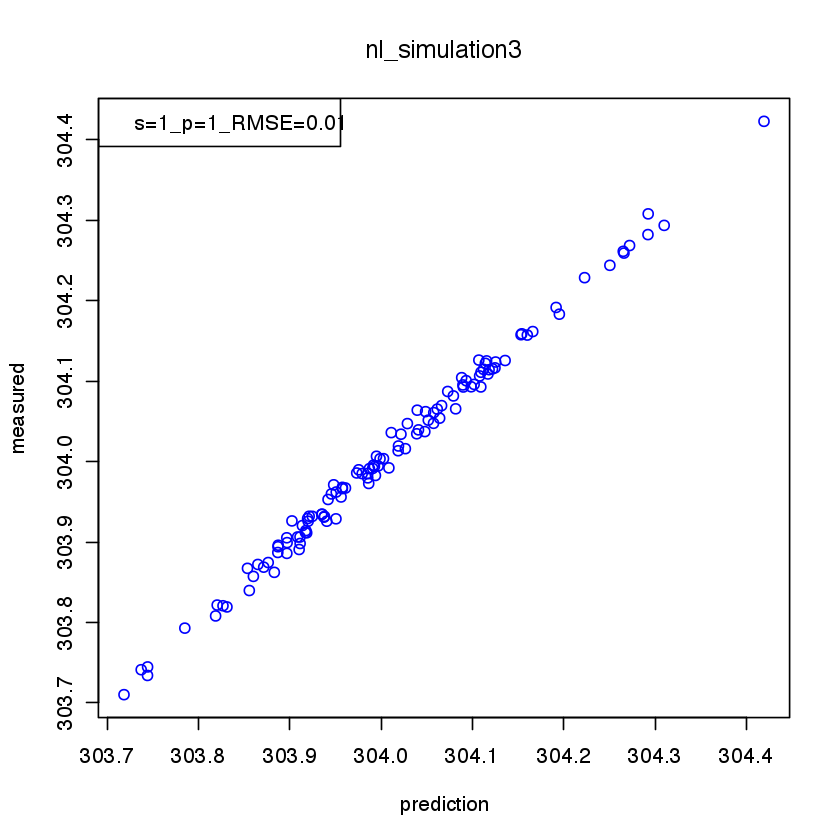

In [67]:
plot.scatter(partition$test$x,partition$test$y,cv.beta.mat.nl$best.nl,0,"measured",main=paste('nl',fileName,sep='_'),is_fl=F,intercept_mode,xlab='prediction')